# Obtaining an explanation

In this notebook we will show how to obtain an explanation for a given model and data image. We will use CIFAR10 as the dataset and a ResNet18 model as the classifier. The explanation will be obtained using the Integrated Gradients method.

In [18]:
import torch
from torch.utils.data.dataloader import DataLoader
from efficientnet_pytorch import EfficientNet
from ReVel.perturbations import get_perturbation
from ReVel.LLEs import get_xai_model
from ReVel.revel.revel import ReVel
from ReVel.load_data import load_data
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
import pandas as pd
import json
import imports
device = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = {'CIFAR10':10,   'CIFAR100':100, 'EMNIST':47,'FashionMNIST':10}

# Cargar la configuración del experimento
with open('config.json', 'r') as f:
    config = json.load(f)

In [6]:
config
num_classes = n_classes[config["dataset_W"]]
perturbation = get_perturbation(name=config["perturbation_W"],
                                 dim=config["features_W"],
                                 num_classes=n_classes[config["dataset_W"]],
                                 final_size=(224,224),
                                 kernel=config["kernel_W"],
                                 max_dist= config["maxDist_W"],
                                 ratio=config["ratio_W"],)
Test = load_data(config["dataset_W"],perturbation = perturbation,train=False,dir="./data")
TestLoader = iter(DataLoader(Test, batch_size=1, shuffle=False))
classifier = EfficientNet.from_name("efficientnet-b2",num_classes=len(Test.classes))
state_dict = torch.load(f"../../../models/classifier_{config['dataset_W']}.pt",map_location=device)
classifier.load_state_dict(state_dict)
classifier.to(device)
classifier.eval()
print("Loaded the pretrained model.")

Files already downloaded and verified
Loaded the pretrained model.


In [7]:
# Load Explainer

explainer = get_xai_model(name=config["xai_model_W"],
                          perturbation=perturbation,
                          max_examples=config["evaluations_W"],
                          dim=config["features_W"],
                          sigma = config["sigma_W"])

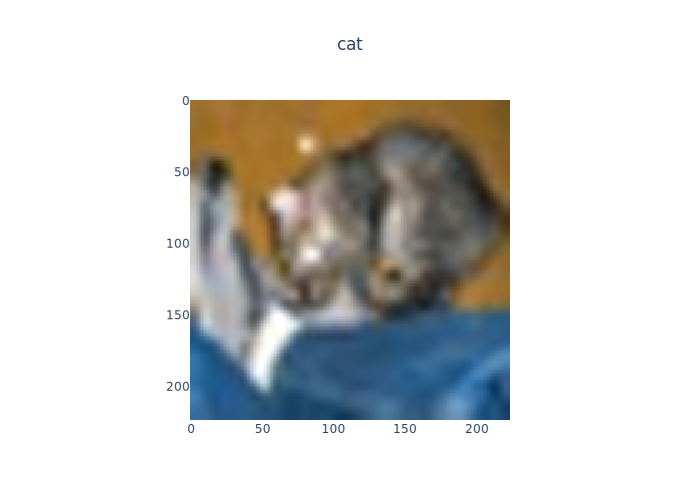

In [8]:
# Select the input to be explained.
inp,target = TestLoader.next()
clase = Test.classes[torch.argmax(target,dim=1)[0]]

figure = go.Figure()
figure.add_trace(go.Image(z=inp[0].permute(1,2,0)))
# Aniade clase como titulo
figure.update_layout(title_text=f"{clase}",title_x=0.5)

figure.show(renderer="svg")

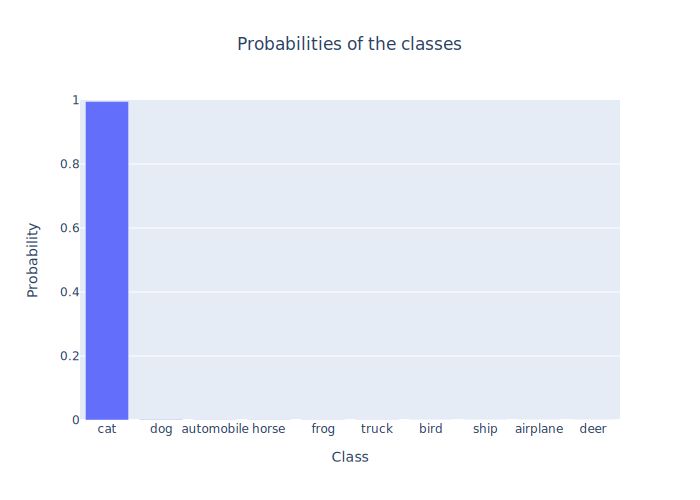

In [9]:
# Pasar inp a float
inp = inp.float()
probabilities = torch.softmax(classifier(inp.to(device)),dim=1)[0]
clas = torch.argmax(probabilities)
args = torch.argsort(probabilities,descending=True)
prob_classes = [(Test.classes[arg],float(probabilities[arg]) ) for arg in args[:10]]
fig = px.bar(prob_classes,x=0,y=1,title="Probabilities of the classes")
fig.update_layout(title_x=0.5)
fig.update_xaxes(title="Class")
fig.update_yaxes(range=[0,1],title="Probability")

fig.show(renderer="svg")
#plt.bar(range(len(prob_classes)),[prob_class[1] for prob_class in prob_classes])

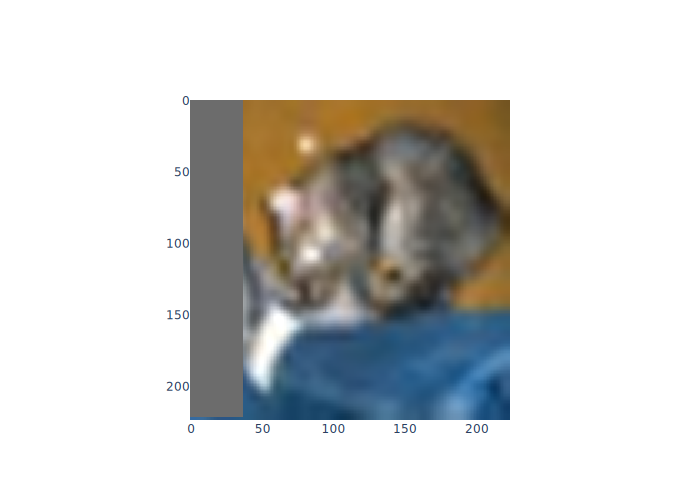

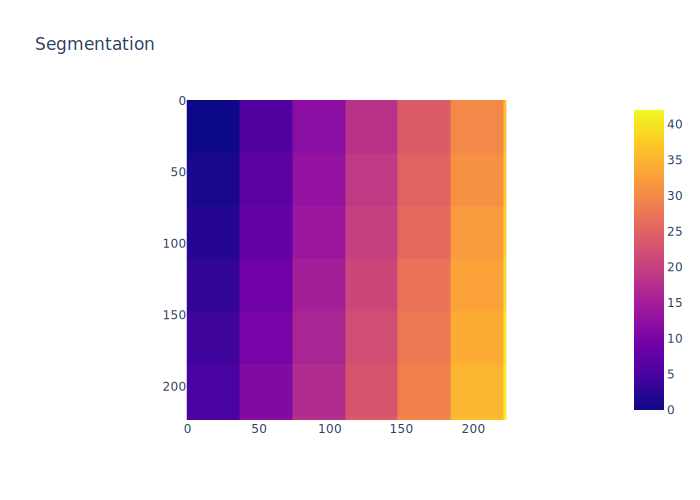

In [10]:
# Genera una perturbacion de inp
var1 = inp.numpy()[0]
var1 = var1.swapaxes(0,1).swapaxes(1,2)
neutralImage = explainer.perturbation.fn_neutral_image(var1)
var = inp.numpy()
var = var[0].transpose(1,2,0)

segments = explainer.perturbation.segmentation_fn(var)



perturbation = explainer.perturbation.perturbation(img=var1,neutral=neutralImage,segments=segments,indexes=[0,1,2,3,4,5])

# mostrar la imagen perturbada con plotly go. La imagen
# perturbada tiene dimensiones (1,3,224,224)
figure = go.Figure()
figure.add_trace(go.Image(z=perturbation))
figure.show(renderer="svg")
# Mostrar los segmentos con plotly go. segments tiene
# dimensiones (224,224)
segs_fig = px.imshow(segments,title="Segmentation")
segs_fig.show(renderer="svg")


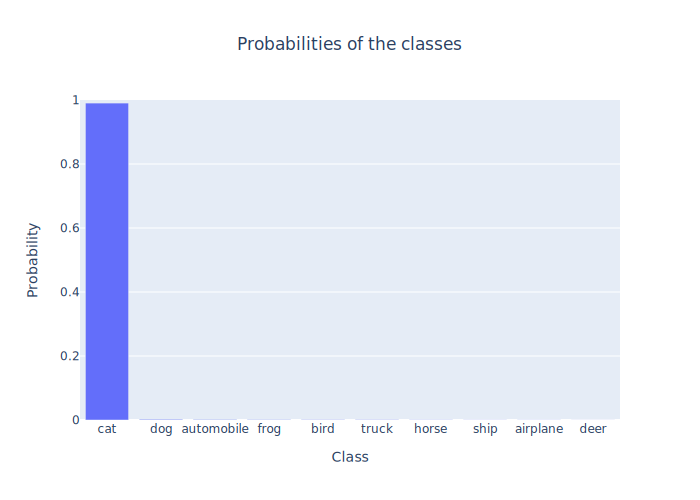

In [11]:
img_perturbated = torch.tensor(perturbation).float()
img_perturbated = img_perturbated.permute(2,0,1)
img_perturbated = img_perturbated.unsqueeze_(0)
probabilities = torch.softmax(classifier(img_perturbated.to(device)),dim=1)[0]
clas = torch.argmax(probabilities)
args = torch.argsort(probabilities,descending=True)

prob_classes = [(Test.classes[arg],float(probabilities[arg]) ) for arg in args[:10]]
fig = px.bar(prob_classes,x=0,y=1,title="Probabilities of the classes")
fig.update_layout(title_x=0.5)
fig.update_xaxes(title="Class")
fig.update_yaxes(range=[0,1],title="Probability")
fig.show(renderer="svg")

## Obtaining explanation
- Define the pipeline fot the image forward and for the feature-space forward

In [12]:
def classify(image,model=classifier):
    '''
    This function takes an image and returns the predicted probabilities.
    :param image: A tensor of shape HxWxC
    :return: A tensor of shape Cx1
    '''
    if isinstance(image, np.ndarray):
        
        image = np.expand_dims(image,0)
        
        image = torch.Tensor(image).to(device)
        
    else:
        image = torch.unsqueeze(image,0)
    
    # image dims: (N,H,W,C) -> (N,C,H,W)
    
    image = torch.transpose(image,3,2).transpose(2,1)
    
    result = model(image)
    return result

def model_fordward(X:np.array,explainator=explainer,model=classify,img=inp):
    '''
    This function takes a feature vector and returns the predicted probabilities of the original img.
    :param X: A tensor of shape F.
    :param explainator: An explainator object.
    :param model: A function that takes an image and returns the predicted probabilities.
        This function accept an image of shape HxWxC and returns a tensor of shape Cx1.
    :param img: The original image.
    :return: A tensor of shape Cx1
    '''
    img = img[0].permute(1,2,0)
    
    neutral = explainator.perturbation.fn_neutral_image(img)
    
    avoid = [i for i in range(len(X)) if X[i] == 0]
    
    segments = explainator.perturbation.segmentation_fn(img.numpy())
    
    
    perturbation = explainator.perturbation.perturbation(img,neutral,segments=segments,indexes=avoid)
    return model(perturbation)

In [13]:
image = inp.numpy()[0]
image = image.swapaxes(0,1).swapaxes(1,2)
explaination = explainer.explain_instance(image,classify,segments)
explaination2 = explainer.explain_instance(image,classify,segments)

100%|██████████| 50/50 [00:02<00:00, 18.44it/s]


In [14]:
image = inp[0].permute(1,2,0).numpy()

revel = ReVel(model_f=classify,
            model_g=model_fordward,
            instance=image,
            lle=explainer,
            n_classes=num_classes,
            segments=segments,)
figures = []
figures2 = []

probabilities = torch.softmax(classifier(inp.to(device)),dim=1)[0]
clas = torch.argmax(probabilities)
args = torch.argsort(probabilities,descending=True)
ids = [clas for clas in args[:10]]
for i in args[:10]:
    image_final = revel.coloured_importance_mask(explaination,segments,i)
    figure = go.Image(z=image_final*256)
    figures.append(figure)
    
    image_final = revel.coloured_importance_mask(explaination2,segments,i)
    figure2 = go.Image(z=image_final*256)
    figures2.append(figure2)
clases = [f"{Test.classes[clas]}: {100*probabilities[clas]:.2f}%" for clas in ids]
fig = make_subplots(rows=2, cols=5, subplot_titles=clases)
fig2 = make_subplots(rows=2, cols=5, subplot_titles=clases)
for i in range(2):
    for j in range(5):
        fig.add_trace(figures[i*5+j],row=i+1,col=j+1)
        fig2.add_trace(figures2[i*5+j],row=i+1,col=j+1)

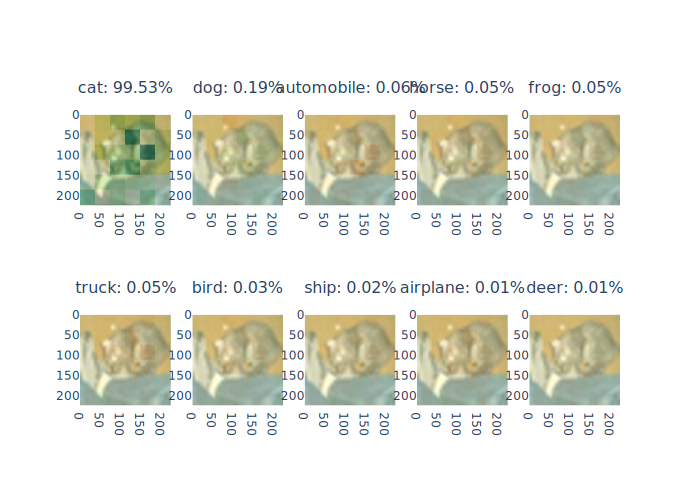

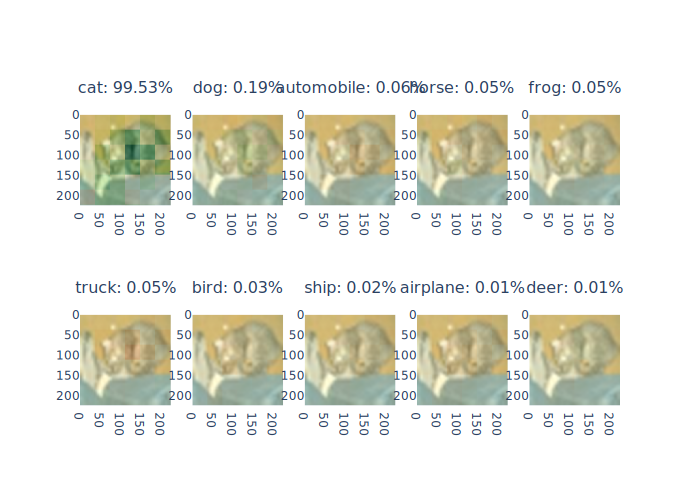

In [15]:
fig.show(renderer="svg")
fig2.show(renderer="svg")

In [16]:
df = revel.evaluate(3)

100%|██████████| 50/50 [00:03<00:00, 15.44it/s]


In [17]:
# Media por columna del df
display(df)
df.mean(axis=0)

,conciseness,local_fidelity,local_concordance,prescriptivity,robustness
0,0.814499,0.995547,0.996425,0.917606,0.846739
1,0.713680,0.997557,0.998880,0.894380,0.846739
2,0.720520,0.996934,0.997695,0.938943,0.846739


conciseness          0.749566
local_fidelity       0.996679
local_concordance    0.997667
prescriptivity       0.916976
robustness           0.846739
dtype: float64

In [14]:
TestLoader = iter(DataLoader(Test, batch_size=1, shuffle=True))
df = pd.DataFrame(columns=["id","conciseness",'local_fidelity','local_concordance','prescriptivity','robustness'])

for i in range(2):
    image, label = next(TestLoader)
    image = inp[0].permute(1,2,0).float()
    segments = explainer.perturbation.segmentation_fn(image.numpy())
    model_f = lambda x: classify(x,model=classifier)
    model_g = lambda x: model_fordward(x,explainator=explainer,model=classify,img=image)
    revel = ReVel(model_f=model_f,
                  model_g=model_fordward,
                  instance=image,
                  lle=explainer,
                  n_classes=num_classes,
                  segments=segments)
    df_local = revel.evaluate(2)
    df_local["id"] = i+1
    # aniade el df_local al df
    df = pd.concat([df,df_local],axis=0)
display(df)

100%|██████████| 50/50 [00:02<00:00, 19.33it/s]


,id,conciseness,local_fidelity,local_concordance,prescriptivity,robustness
0,1,0.762658,0.996932,0.998234,0.852824,0.907456
1,1,0.741459,0.995373,0.996122,0.884971,0.907456
0,2,0.744504,0.997902,0.999221,0.806281,0.912736
1,2,0.705440,0.998052,0.999528,0.958382,0.912736


In [15]:
df_example = df.groupby("id").mean()
display(df_example)
display(df_example.mean(axis=0))


,conciseness,local_fidelity,local_concordance,prescriptivity,robustness
id,,,,,
1,0.752059,0.996153,0.997178,0.868897,0.907456
2,0.724972,0.997977,0.999374,0.882331,0.912736


conciseness          0.738515
local_fidelity       0.997065
local_concordance    0.998276
prescriptivity       0.875614
robustness           0.910096
dtype: float64